# CCD Processing through to photometry

In this notebook, we'll do our basic CCD processing, then perform some photometry.

# Index

* [Biases](#Biases-&amp;-Readnoise)
* [Flats](#Flats)
* [Flat Uncertainty](#Flat-uncertainty)
* [Flat Normalization](#Flat-normalization)
* [Normalized Flat uncertainty](#Normalized-Flat-Uncertainty)
* [Dark Average](#Dark-Average)
* [Science Images](#Science-Images)
* [Saving FITS files](#Saving)
* [Summary](#Summary)
* [Review Questions](#Review-Questions)
* [Exercise](#Exercise)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pylab as pl
pl.rcParams['image.origin'] = 'lower' # make images display right-side-up
pl.style.use('dark_background')

In [3]:
import glob
import os

A large part of data reduction is 'bookkeeping', i.e., getting the right files into the right place, then using the right files for various simple operations.

We use the `glob` package to find files.  `glob` allows you to use the `*` wildcard to find files.  `*` matches anything - any character or number.  So, for example, if we want to find all of our _bias_ files, and we know they're named `bias_0s_001.FIT`, `bias_0s_002.FIT`, etc, we can use `glob.glob("bias_0s_*.FIT")` to match all of the bias files simultaneously.

In [4]:
# on my computer, the data are in a subdirectory called 'data/', so I chdir there
os.chdir('data/')

In [5]:
biases = glob.glob('bias_0s_*.FIT')
biases

['bias_0s_001.FIT',
 'bias_0s_002.FIT',
 'bias_0s_003.FIT',
 'bias_0s_004.FIT',
 'bias_0s_005.FIT',
 'bias_0s_006.FIT',
 'bias_0s_007.FIT',
 'bias_0s_008.FIT',
 'bias_0s_009.FIT',
 'bias_0s_010.FIT']

We want to work on a 30s exposure, so we want our 30s darks:

In [6]:
# [12345] means "any number 1,2,3,4, or 5" - it's like "*", but narrower
darks = glob.glob("dark_30s_00[12345].FIT")
darks

['dark_30s_001.FIT',
 'dark_30s_002.FIT',
 'dark_30s_003.FIT',
 'dark_30s_004.FIT',
 'dark_30s_005.FIT']

We also want to _flat field_ our "clear" images, so we'll grab those too:

In [7]:
clear_flat = glob.glob("flat_0p65*FIT")
clear_flat

['flat_0p65_clear_001.FIT',
 'flat_0p65_clear_002.FIT',
 'flat_0p65_clear_003.FIT',
 'flat_0p65_clear_004.FIT',
 'flat_0p65_clear_005.FIT',
 'flat_0p65_clear_006.FIT',
 'flat_0p65_clear_007.FIT',
 'flat_0p65_clear_008.FIT',
 'flat_0p65_clear_009.FIT',
 'flat_0p65_clear_010.FIT']

Note that all of these operations required that the file names are correct!  If you make a mistake when naming your files at the telescope, it is important to correct that error by renaming the file.

### Biases & Readnoise

[Index](#Index)

We now do some of our basic operations.  We average all of the bias frames, _and_ we obtain their standard deviation so we have an estimate of the readnoise.

In [8]:
from astropy.io import fits

In [9]:
bias_timestream = [fits.getdata(x) for x in biases]
mean_bias = np.mean(bias_timestream, axis=0)
stddev_bias = np.std(bias_timestream, axis=0)
readnoise = np.mean(stddev_bias)

In [10]:
# aside: your computer may run out of memory from loading a bunch of files!
# To limit how much data is kept in memory, we can delete variables that contain a lot of data when we're done with them:
del bias_timestream

We calculate the per-pixel uncertainty in the bias image using the usual Gaussian error propagation formula.

The error per read is given by `readnoise`.

The `mean_bias` is the average of 10 reads, so the noise in this image - which is only readnoise - is lower than the per-exposure readnoise by $\sqrt{10}$.  

(recall that the `readnoise` will be a single number, not an image, because the readout is happening in just one place in the CCD, not in each pixel)

In [11]:
mean_bias_noise = readnoise / np.sqrt(len(biases))
mean_bias_noise

3.2853831766636805

### Flats
[Index](#Index)

Then, we average all of the flat field images:

In [12]:
clear_flat_timestream = [fits.getdata(x) for x in clear_flat]
mean_clear_flat = np.mean(clear_flat_timestream, axis=0)
del clear_flat_timestream

Our flat field exists to account for varying response to incoming light across the field of view.  The _bias_ image contains all of the electronic cruft that is present before we even start taking an image, so it does not represent a response to incoming light.

We therefore want to subtract the bias from the flat field (note that it would also be reasonable to subtract a dark image from the flat field, but with an exposure time of 0.65s, we expect negligible dark current):

In [13]:
bias_subtracted_clear_flat = mean_clear_flat - mean_bias

### Flat uncertainty
[Index](#Index)

To estimate the uncertainty in the flat field, we combine the Poisson error with the read noise.

The best estimate we can get of the Poisson error is from the `bias_subtracted_clear_flat`: it is our measurement of how many photons we got per exposure.  Since the bias is subtracted, we are not (incorrectly) including bias in our photon count.

How many photons do we receive?  It should be the number of ADUs multiplied by the 'EGAIN' in the header, 
```
EGAIN   = +2.230000000000E+000 / ELECTRONS PER ADU                              
```

In [14]:
gain = fits.getheader('flat_0p65_clear_001.FIT')['EGAIN']

In [15]:
flat_poisson_uncertainty = (bias_subtracted_clear_flat * gain)**0.5

Then, we have to add back the uncertainty from read noise.

In [16]:
flat_singleframe_uncertainty = (flat_poisson_uncertainty**2 + readnoise**2)**0.5

Since we took the _mean_ of several frames, the uncertainty in the mean is _lower_ than that in the individual frames by $\sqrt{N_{frames}}$.

However, we also subtracted the bias, so we need to add the noise associated with the bias frame.

In [17]:
flat_total_uncertainty = ((flat_singleframe_uncertainty/np.sqrt(len(clear_flat)))**2 + mean_bias_noise**2)**0.5

### Flat Normalization
[Index](#Index)

Finally, because we want to use the flat field as a multiplicative correction, we need to _normalize_ it first.  The `bias_subtracted_flat` has a very high mean because it includes a lot of photons from the sky:

In [18]:
mean_of_flat = np.mean(bias_subtracted_clear_flat)
mean_of_flat

17047.405846562877

To normalize, we divide the image by the mean value in the image.  

The term _normalize_ is frequently used in statistics and data analysis.  In this case, we are normalizing by the mean, but it is possible to normalize to other values (e.g., the sum).

After this operation, the mean value of the normalized image will be 1:

In [19]:
normalized_mean_clear_flat = bias_subtracted_clear_flat / mean_of_flat
np.mean(normalized_mean_clear_flat)

1.0000000000000002

So if we divide by this image, we aren't changing the _average_ flux received, we're only changing how much goes to each part of the image.

You can see by the colorbar that the variation in the flat field is small - as low as 8% below the mean or as high as 5% above (0.92 to 1.05 is the range on the colorbar).  It's good if our correction is small!

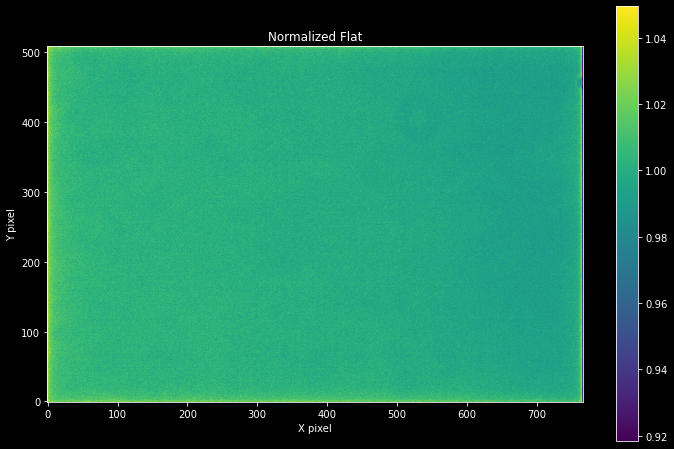

In [20]:
pl.figure(figsize=(12,8))

_=pl.imshow(normalized_mean_clear_flat, origin='lower', interpolation='none')
_=pl.colorbar()
_=pl.title("Normalized Flat")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

## Normalized Flat Uncertainty
[Index](#Index)

Following the propagation of error formulae, for $z = a * x$, $\sigma_z^2 = a^2 \sigma_x^2$.

When we normalize, we're dividing by a constant - in this case, a big one, 17000 or so.

The uncertainty is similarly reduced!

In [21]:
normalized_flat_uncertainty = flat_total_uncertainty / mean_of_flat

The uncertainty on the flat should be very small, much smaller than the values across the flat.

We can see that the typical uncertainty is, indeed, around 0.3%, substantially less than the flat-field correction factor, which is about 1.

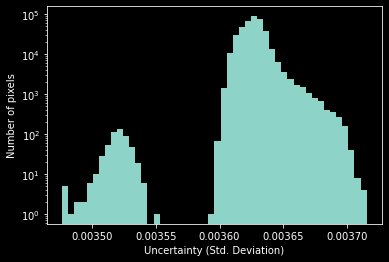

In [22]:
pl.xlabel("Uncertainty (Std. Deviation)")
pl.ylabel("Number of pixels")
_=pl.hist(normalized_flat_uncertainty.ravel(), bins=50, log=True)

We can look at the per-pixel signal-to-noise ratio in the flat field and see that its around 275 in each pixel.

That's good - but be warned, if we want to make a measurement accurate to <0.1% in one pixel, this wouldn't be good enough!

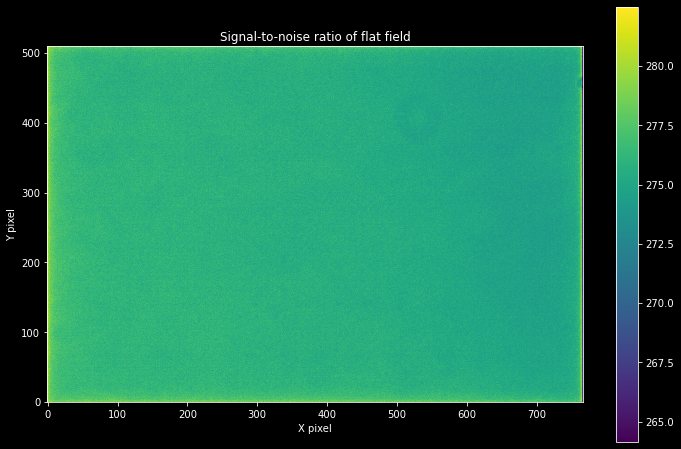

In [23]:
pl.figure(figsize=(12,8))
pl.title("Signal-to-noise ratio of flat field")
pl.imshow(normalized_mean_clear_flat / normalized_flat_uncertainty, origin='lower', interpolation='none')
pl.colorbar()
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

## Dark Average

[Index](#Index)

We now average the darks whose exposure times are matched to that of our image (we will compare to a 30s exposure):

In [24]:
darks_30s = [fits.getdata(x) for x in darks]
average_30s_dark = np.mean(darks_30s, axis=0)
stddev_30s_dark = np.std(darks_30s, axis=0)
del darks_30s

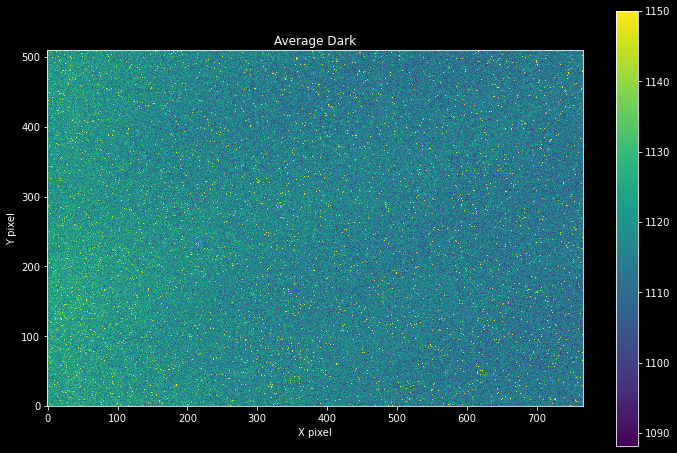

In [25]:
pl.figure(figsize=(12,8))
pl.imshow(average_30s_dark, origin='lower', interpolation='none', vmax=1150)
pl.colorbar()
_=pl.title("Average Dark")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

We can take two different approaches for measuring the uncertainty in the darks:

 1. We could use the same approach as the flats, and measure the electron-counting uncertainty separately from the read noise, then determine the total error by propagation rules
 2. We could measure the per-pixel error directly from the data.
 
In this case, we adopted approach #2, but this is only advisable if you have many darks - 5 is probably enough, but 3 is generally not.

In [26]:
uncertainty_on_30s_mean_dark = stddev_30s_dark / np.sqrt(len(darks))

# Science Images

[Index](#Index)

Finally, let's do our first operation with a "science image", a snapshot of the Pleiades:

In [27]:
pleiades_clear = fits.getdata('pleadese_30s_C_other_001.FIT')

We show the image with a scaling that lets us see the stars and the noise.  We also have a look at a histogram of the data to see if the data look reasonable.  We use log-scaling for the histogram because the vast majority of the pixels have about the same value, which is the value expected for seeing no photons (blank sky).

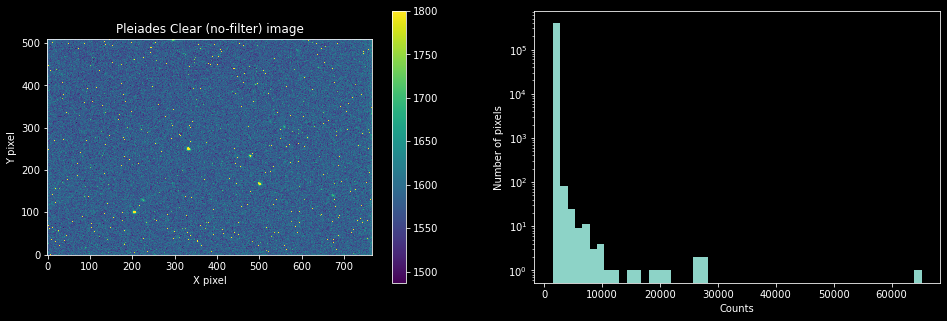

In [28]:
pl.figure(figsize=(16,5))
im = pl.subplot(1,2,1).imshow(pleiades_clear, origin='lower', interpolation='none', vmax=1800,)
_=pl.title("Pleiades Clear (no-filter) image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
pl.colorbar(im)

_ = pl.subplot(1,2,2).hist(pleiades_clear.ravel(), bins=50, log=True)
_ = pl.xlabel("Counts")
_ = pl.ylabel("Number of pixels")

From the histogram, there are clearly some hot pixels.  Dark subtraction will remove most of them.

In [29]:
pleiades_clear_darksub = pleiades_clear - average_30s_dark

We calculate the uncertainty as: Poisson error plus readnoise plus the uncertainty on the dark.

$$ \sigma_{Poisson}^2 = S$$
$$ \sigma_{darksub} = \sqrt{\sigma_{Poisson}^2 + \sigma_{RN}^2 + \sigma_{dark}^2}$$

In [30]:
pleiades_clear_darksub_uncertainty = (pleiades_clear_darksub + readnoise**2 + uncertainty_on_30s_mean_dark**2)**0.5

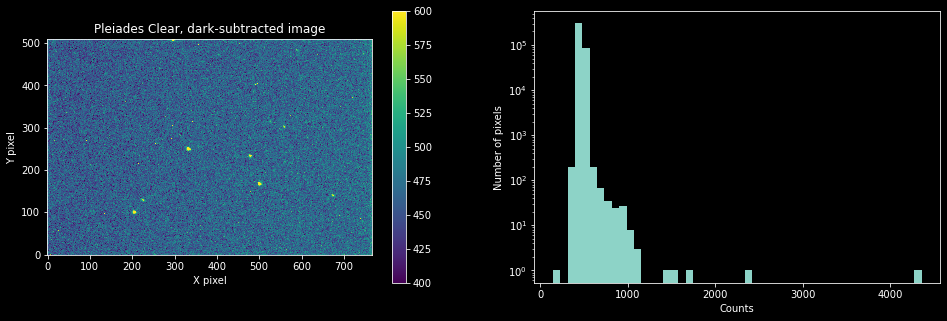

In [31]:
pl.figure(figsize=(16,5))
im = pl.subplot(1,2,1).imshow(pleiades_clear_darksub, origin='lower', interpolation='none', vmax=600, vmin=400)
_=pl.title("Pleiades Clear, dark-subtracted image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
pl.colorbar(im)

_ = pl.subplot(1,2,2).hist(pleiades_clear_darksub.ravel(), bins=50, log=True)
_ = pl.xlabel("Counts")
_ = pl.ylabel("Number of pixels")

There are still very few bright pixels compared to the number of faint, noisy pixels, but that's expected as the stars fill a very small area on the image.

The next step is to flatten the image by dividing by our normalized flat:

In [32]:
pleiades_clear_darksub_flattened = pleiades_clear_darksub / normalized_mean_clear_flat

Again, we propagate error - this time with the division rule.
$$ z = x/y $$
$$ \frac{\sigma_z^2}{z^2} = \frac{\sigma_x^2}{x^2} + \frac{\sigma_y^2}{y^2}$$

In [33]:
pleiades_clear_darksub_flattened_uncertainty = ((
    pleiades_clear_darksub_uncertainty**2 / pleiades_clear_darksub**2 +
    normalized_flat_uncertainty**2 / normalized_mean_clear_flat**2
) * pleiades_clear_darksub_flattened**2)**0.5

In [34]:
c = pleiades_clear_darksub_flattened_uncertainty

Or, equivalently  (this is what you get if you multiply both sides by $z^2$):

$$ {\sigma_z^2} = \frac{\sigma_x^2 }{y^2} + \frac{\sigma_y^2 x^2}{y^4}$$

In [35]:
pleiades_clear_darksub_flattened_uncertainty = ((
    pleiades_clear_darksub_uncertainty**2 / normalized_mean_clear_flat**2 +
    normalized_flat_uncertainty**2 * pleiades_clear_darksub**2 / normalized_mean_clear_flat**4
))**0.5

To make sure you can see what we did, the cell above is using:
 * $\sigma_x = $`pleiades_clear_darksub_uncertainty`

 * $y =$ `normalized_mean_clear_flat`
 * $\sigma_y = $ `normalized_flat_uncertainty`
 * $x = $ `pleiades_clear_darksub`
 * $z = x/y =$ `pleiades_clear_darksub` / `normalized_mean_clear_flat`

After we've flat-fielded, the image is _slightly_ improved:

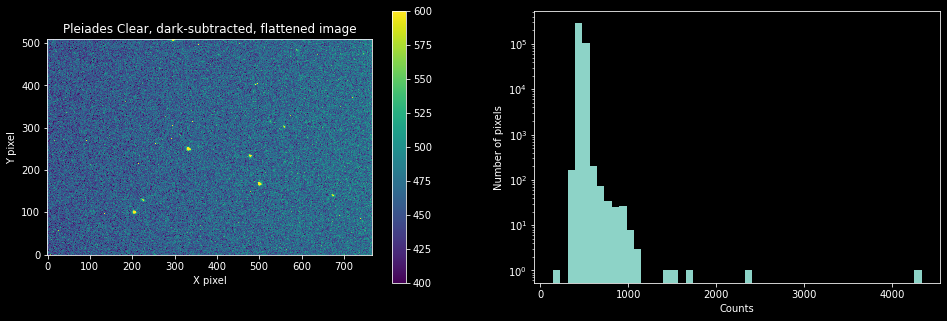

In [36]:
pl.figure(figsize=(16,5))
im = pl.subplot(1,2,1).imshow(pleiades_clear_darksub_flattened, origin='lower', interpolation='none', vmax=600, vmin=400)
pl.colorbar(im)
_=pl.title("Pleiades Clear, dark-subtracted, flattened image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

_ = pl.subplot(1,2,2).hist(pleiades_clear_darksub_flattened.ravel(), bins=50, log=True)
_ = pl.xlabel("Counts")
_ = pl.ylabel("Number of pixels")

There is still some gradient across the image, but in theory at least, this should be an improvement over the original.

We can see what our _signal to noise_ ratio is everywhere too:

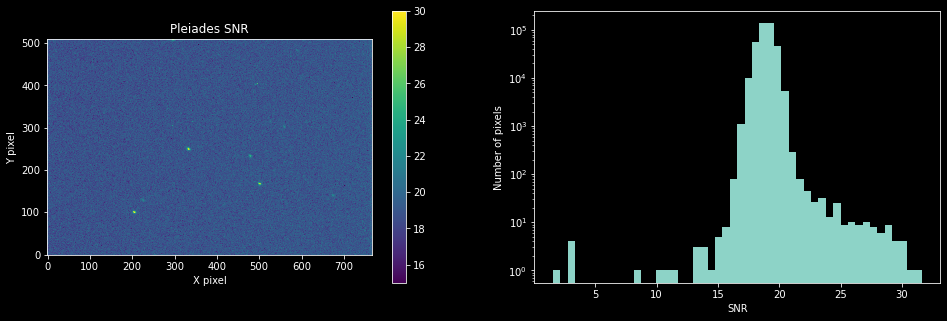

In [37]:
pl.figure(figsize=(16,5))
SNR = pleiades_clear_darksub_flattened / pleiades_clear_darksub_flattened_uncertainty
im = pl.subplot(1,2,1).imshow(SNR, origin='lower', interpolation='none', vmin=15, vmax=30)
_=pl.title("Pleiades SNR")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
pl.colorbar(im)

_ = pl.subplot(1,2,2).hist(SNR.ravel(), bins=50, log=True)
_ = pl.xlabel("SNR")
_ = pl.ylabel("Number of pixels")

You might notice that we have a SNR > 15 almost everywhere!  That's probably because of the _sky background_ that we have not yet removed.  We'll need to do that.

A peak SNR $\sim$ 30 isn't very good, but that's  not surprising since we only got $\sim$ a few thousand photons at most.

## Saving
[Index](#Index)

Now, we _may_ want to save our results.  We can do this using FITS tools:

In [38]:
header = fits.getheader('pleadese_30s_C_other_001.FIT')
filehandle = fits.PrimaryHDU(data=pleiades_clear_darksub_flattened, header=header)
filehandle.writeto('pleiades_30s_C_other_001_darksub_flattened.fits', overwrite=True)

In [39]:
header = fits.getheader('pleadese_30s_C_other_001.FIT')
filehandle = fits.PrimaryHDU(data=pleiades_clear_darksub_flattened_uncertainty, header=header)
filehandle.writeto('pleiades_30s_C_other_001_darksub_flattened_uncertainty.fits', overwrite=True)

## Summary
[Index](#Index)

At this point, we have:

 1. Averaged our dark images
 2. Averaged our bias images
 3. Subtracted the mean bias from the flat field image
 4. Normalized the flat field image
 5. Subtracted the appropriate mean dark from the science image
 6. Divided the science image by the normalized flat field

and propagated error along the way.  We now have one "fully reduced" science frame.

To obtain our final data products, we will repeat this process for _every_ science frame!

This is actually pretty easy, though, as we don't have to repeat steps 1-4, and we can automate steps 5 and 6.

You will do this for the data analysis steps, but there are some other steps involved too.

## Review Questions
[Index](#Index)

What is the command to delete a variable?  Why would you want to do this?

What is the error propagation formula for $z = a * x$, where $a$ is a constant?

What is the error propagation formula for division, i.e., $z = x / y$?

What is the average value of the normalized flat field?

## Exercise
[Index](#Index)

Repeat all of the above steps for your data from Lab 5.

Do this for at least one image from a mosaic and at least one image of Algol.

Please do this work in your own notebook.  It may be easiest to do if you have this notebook open alongside your work.